In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
import tensorflow as tf
from tensorflow import keras

BATCH_SIZE = 100_000
samples = os.path.join(cwd, "data", "train", "2D", "MIP")

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = None,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    follow_links = False
)

Found 489622 files belonging to 1 classes.


2024-02-26 17:48:53.455964: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-26 17:48:53.455999: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-26 17:48:53.456002: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-26 17:48:53.456250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-26 17:48:53.456658: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
for X in train_dataset.take(1):
    pass

2024-02-26 17:49:03.738313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 320122 of 800000
2024-02-26 17:49:09.469484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


In [5]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = (y == 1)

In [6]:
print(X.numpy().astype(str)[0])

dataset: C
instance: TR
+-----------+
2D Packing MIP with Time Limit 23.711758972067194 [s] in Truck P073421601
Stack 0 with items: ['0090017000_27022023035977', '0090017000_27022023032477', '0090017000_27022023032477']
Stack 1 with items: ['0090017000_27022023027478', '0090017000_27022023022949', '0090017000_27022023027478']
Stack 2 with items: ['0090017000_27022023022697', '0090017000_27022023017594', '0090017000_27022023019906', '0090017000_27022023004110']
Stack 3 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 4 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 5 with items: ['0090017000_27022023004795', '0090017000_27022023004795', '0090017000_27022023029600']
Stack 6 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 7 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_270220230296

In [7]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: C
instance: TR
+-----------+
2D Packing MIP with Time Limit 23.711758972067194 [s] in Truck P073421601
Stack 0 with items: ['0090017000_27022023035977', '0090017000_27022023032477', '0090017000_27022023032477']
Stack 1 with items: ['0090017000_27022023027478', '0090017000_27022023022949', '0090017000_27022023027478']
Stack 2 with items: ['0090017000_27022023022697', '0090017000_27022023017594', '0090017000_27022023019906', '0090017000_27022023004110']
Stack 3 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 4 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 5 with items: ['0090017000_27022023004795', '0090017000_27022023004795', '0090017000_27022023029600']
Stack 6 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_27022023029600']
Stack 7 with items: ['0090017000_27022023029600', '0090017000_27022023029600', '0090017000_270220230296

# Processing functions:

## Extract raw data

In [8]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [9]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: C ins…",0,"""P073421601""","""C""","""TR"""
"""dataset: C ins…",1,"""P088167103""","""C""","""BY3"""
"""dataset: X ins…",2,"""P186037405""","""X""","""MA"""
"""dataset: C ins…",3,"""P069040301""","""C""","""DO"""
"""dataset: C ins…",4,"""P090161415""","""C""","""BY"""


## Explode instance into stacks:

In [10]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P073421601""","""C""","""TR""","""Stack 0 with i…",0,"[""0090017000_27022023035977"", ""0090017000_27022023032477"", ""0090017000_27022023032477""]"
0,"""P073421601""","""C""","""TR""","""Stack 1 with i…",1,"[""0090017000_27022023027478"", ""0090017000_27022023022949"", ""0090017000_27022023027478""]"
0,"""P073421601""","""C""","""TR""","""Stack 2 with i…",2,"[""0090017000_27022023022697"", ""0090017000_27022023017594"", … ""0090017000_27022023004110""]"
0,"""P073421601""","""C""","""TR""","""Stack 3 with i…",3,"[""0090017000_27022023029600"", ""0090017000_27022023029600"", ""0090017000_27022023029600""]"
0,"""P073421601""","""C""","""TR""","""Stack 4 with i…",4,"[""0090017000_27022023029600"", ""0090017000_27022023029600"", ""0090017000_27022023029600""]"


## Explode stacks into items:

In [12]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",1,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",1,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",1,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",2,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",2,"""0090017000_270…"
0,"""P073421601""","""C""","""TR""",2,"""0090017000_270…"


## Load and Merge Items

In [14]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
679301,null,90016900,"""169GB-20""","""8200665427""","""MTEM--4462""",2.4,1.2,1.62,0.457104,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.575
22060301,null,90016900,"""169GB-10""","""745466747R""","""SLI---1200""",1.6,1.2,0.93,0.467056,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885
1925700,null,90016900,"""GRF1""","""682003577R""","""ECM---6632""",2.4,2.1,1.49,0.5186,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.445
2573225,null,90016900,"""169GB-10""","""8200656498""","""SLI---0901""",1.6,1.2,0.75,0.3353,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.705
22060301,null,90016900,"""169GB-30""","""755117870R""","""MTEM--5201""",3.2,1.2,1.49,0.605548,0.045,"""C""","""BY""","""0090016900_270…",false,false,1.445


In [15]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [16]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…",27522803,null,90017000,"""V55""","""964009860R""","""SLI---2112""",1.206,1.01,0.385,0.026577,0.0,false,false,0.385
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…",27522803,null,90017000,"""V55""","""964019009R""","""SLI---2112""",1.206,1.01,1.185,0.2206,0.0,false,false,1.185
0,"""P073421601""","""C""","""TR""",0,"""0090017000_270…",27522803,null,90017000,"""V55""","""964019009R""","""SLI---2112""",1.206,1.01,1.185,0.2206,0.0,false,false,1.185
0,"""P073421601""","""C""","""TR""",1,"""0090017000_270…",27522803,null,90017000,"""V55""","""964001360R""","""SLI---2112""",1.206,1.01,1.185,0.2206,0.0,false,false,1.185
0,"""P073421601""","""C""","""TR""",1,"""0090017000_270…",27522803,null,90017000,"""V55""","""964011243R""","""SLI---2112""",1.206,1.01,0.385,0.027565,0.0,false,false,0.385


## Group by stack ID:

In [17]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.467777,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.468765,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",4,1.206,1.01,2.34,0.0,0.302063,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""


# Data Vis:

## Data Prep

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [20]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.467777,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.468765,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",4,1.206,1.01,2.34,0.0,0.302063,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""


### Number of unique stacks over number of stacks:

In [21]:
XX = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .group_by(["index"], maintain_order=True)
    .agg([
        pl.count(["item_id"]).alias("n_stacks"),
        pl.col(["item_id"]).list.join("-").n_unique().alias("nunique_stacks")
    ])
    .with_columns([
        (pl.col("nunique_stacks") / pl.col("n_stacks")).alias("unique_ratio")
    ])
    .collect()
)

assert all(XX["n_stacks"] >= XX["nunique_stacks"])

XX.head(5)

index,n_stacks,nunique_stacks,unique_ratio
i64,u32,u32,f64
0,15,7,0.466667
1,15,5,0.333333
2,24,15,0.625
3,20,20,1.0
4,12,9,0.75


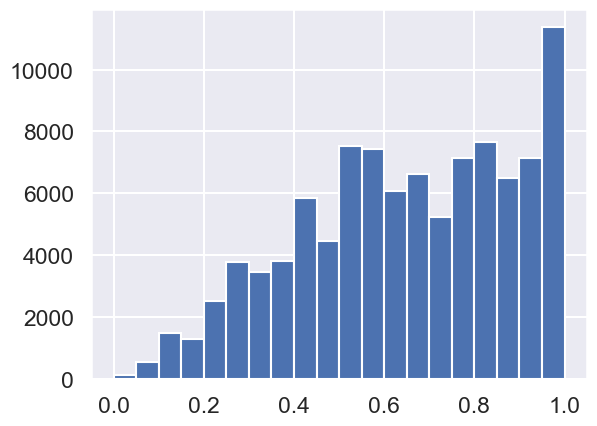

In [22]:
binwidth=0.05
plt.hist(
    XX["unique_ratio"],
    bins=np.arange(0, 1+binwidth, binwidth)
);

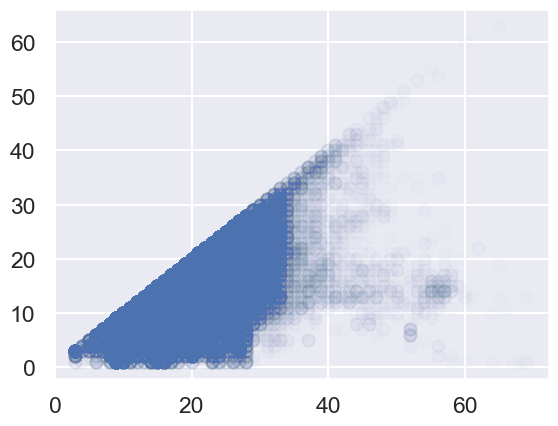

In [23]:
plt.scatter(
    XX["n_stacks"],
    XX["nunique_stacks"],
    alpha=0.01
);

In [24]:
XX

index,n_stacks,nunique_stacks,unique_ratio
i64,u32,u32,f64
0,15,7,0.466667
1,15,5,0.333333
2,24,15,0.625
3,20,20,1.0
4,12,9,0.75
5,17,4,0.235294
6,20,18,0.9
7,31,21,0.677419
8,17,4,0.235294


## 2x2 Stacks and items

Min number of items 4
Max number of items 275
Min number of stacks 3
Max number of stacks 69
Maximum number of items per stack 10


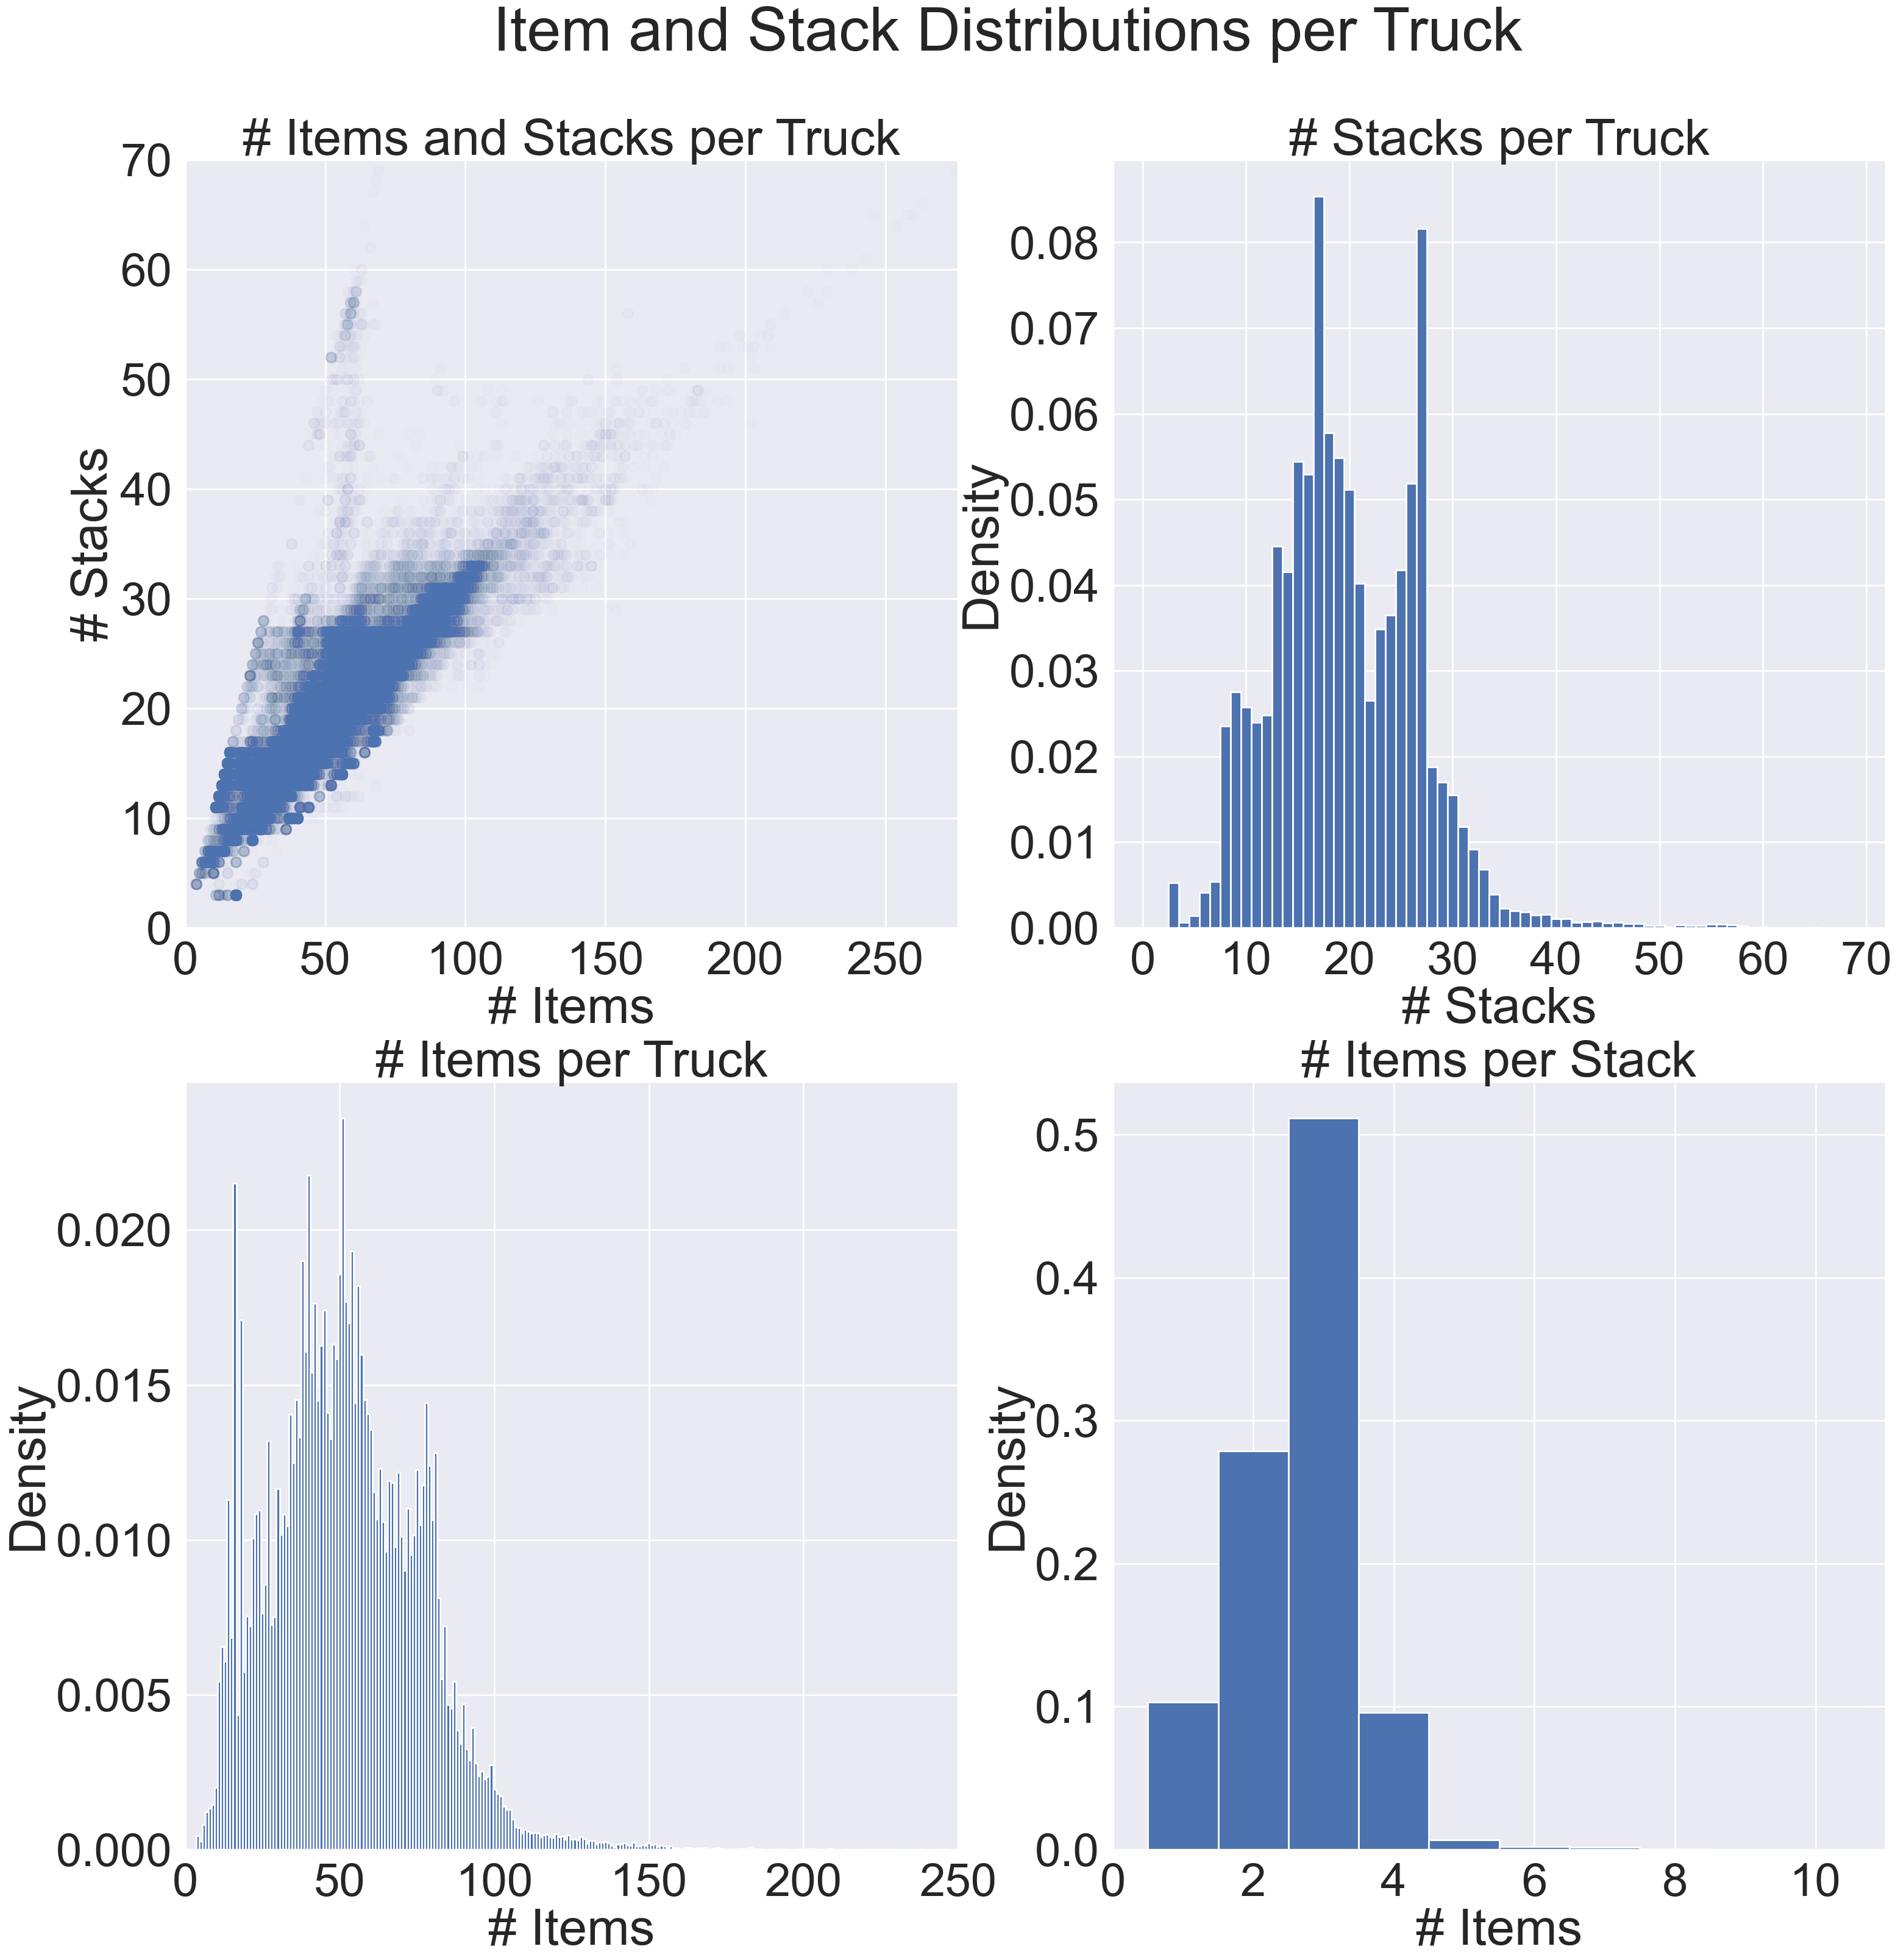

In [29]:
sns.set(context="poster", font_scale=2.5)

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_min = x.min()[0, "total_items"]; print("Min number of items", item_min)
item_max = x.max()[0, "total_items"]; print("Max number of items", item_max)
stack_min = x.min()[0, "total_stacks"]; print("Min number of stacks", stack_min)
stack_max = x.max()[0, "total_stacks"]; print("Max number of stacks", stack_max)

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(
    xlim=[0, item_max+1],
    ylim=[0, stack_max+1],
    title="# Items and Stacks per Truck",
    xlabel="# Items",
    ylabel="# Stacks",
)

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5, density=True)
ax[0, 1].set(
    title="# Stacks per Truck",
    xlabel="# Stacks",
    ylabel="Density"
)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5, density=True)
ax[1, 0].set(
    #xlim=[0, item_max+1],
    xlim=[0, 250],
    title="# Items per Truck",
    xlabel="# Items",
    ylabel="Density"
)



x = X["items"].to_numpy(); print("Maximum number of items per stack", max(x))
ax[1, 1].hist(x, bins=np.arange(0, 10+1, 1)+0.5, density=True);
ax[1, 1].set(
    title="# Items per Stack",
    xlabel="# Items",
    ylabel="Density",
)

plt.suptitle(
    "Item and Stack Distributions per Truck",
    #fontsize=30,
    y=.95
);

#fs = 30
#for axi in ax:
#    for axii in axi:
#        axii.xaxis.label.set_size(fs)     # change xlabel size
#        axii.yaxis.label.set_size(fs)     # change ylabel size
#        axii.title.set_size(fs)

for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"stack-item-distribution.{file_format}")
    plt.savefig(save_path)

sns.set(context="talk")

In [26]:
a

NameError: name 'a' is not defined

## MIP Improvements:

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_81512/1478950873.py:27: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  y_first_update = y_first_update.apply(lambda x: np.nan if x == 0 else x)


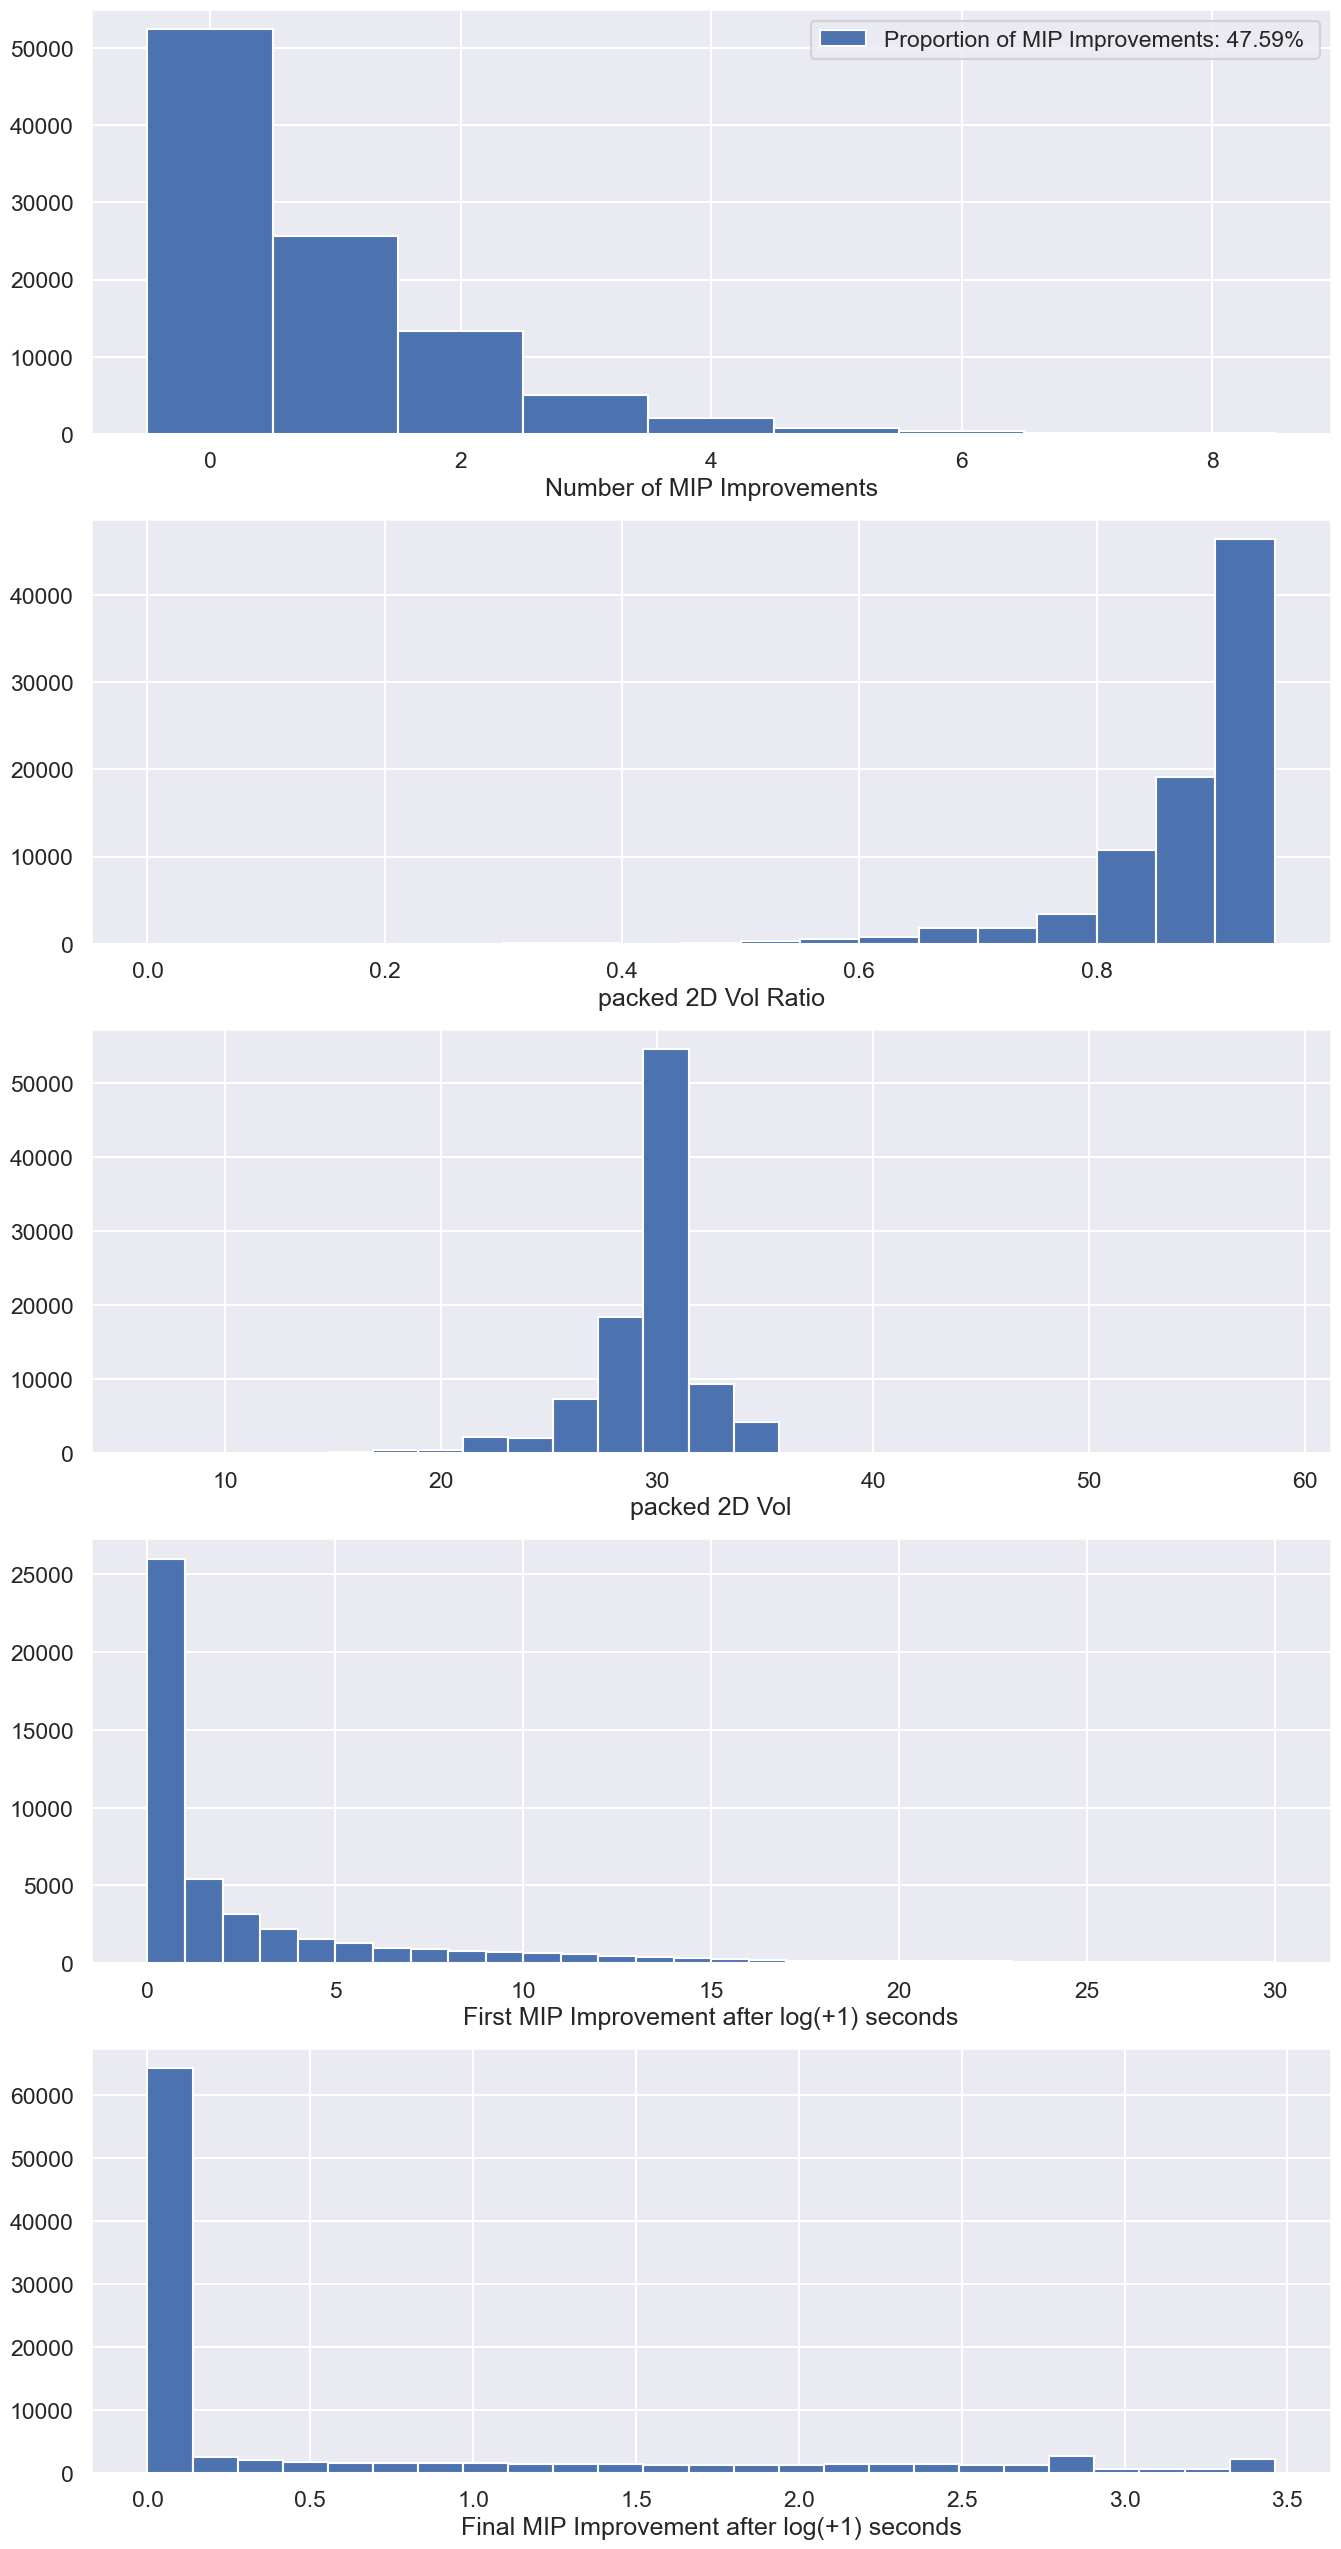

In [39]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

fig, ax = plt.subplots(5, figsize = (16, 32))

y_num_improvements = mip_improvements.list.len()-1
ax[0].hist(y_num_improvements, bins = np.arange(0, 10, 1)-0.5,
           label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%} ");
ax[0].set(xlabel="Number of MIP Improvements")

y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax[1].hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.05));
ax[1].set(xlabel="packed 2D Vol Ratio")

#ax[2].hist((y_packed_area_ratio)**10, bins = 25);
#ax[2].set(xlabel="packed 2D Vol Ratio to the power 10")

y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
ax[2].hist(y_packed_area, bins = 25);
ax[2].set(xlabel="packed 2D Vol")





y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
y_first_update = y_first_update.apply(lambda x: np.nan if x == 0 else x)
ax[3].hist(y_first_update, bins = np.arange(0, 31, 1));
#ax[3].hist(np.log1p(y_first_update), bins = 25);
ax[3].set(xlabel="First MIP Improvement after log(+1) seconds")




y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)
ax[4].hist(np.log1p(y_last_update), bins = 25);
ax[4].set(xlabel="Final MIP Improvement after log(+1) seconds")


ax[0].legend();

#mip_improvements

/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_81512/132755551.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_yticklabels(['{:,.0%}'.format(x) for x in vals]);
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_81512/132755551.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
/var/folders/j4/qmf6qmvd1gv0nctgx3m6jm3r0000gn/T/ipykernel_81512/132755551.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_yticklabels(['{:,.0%}'.format(x) for x in vals]);


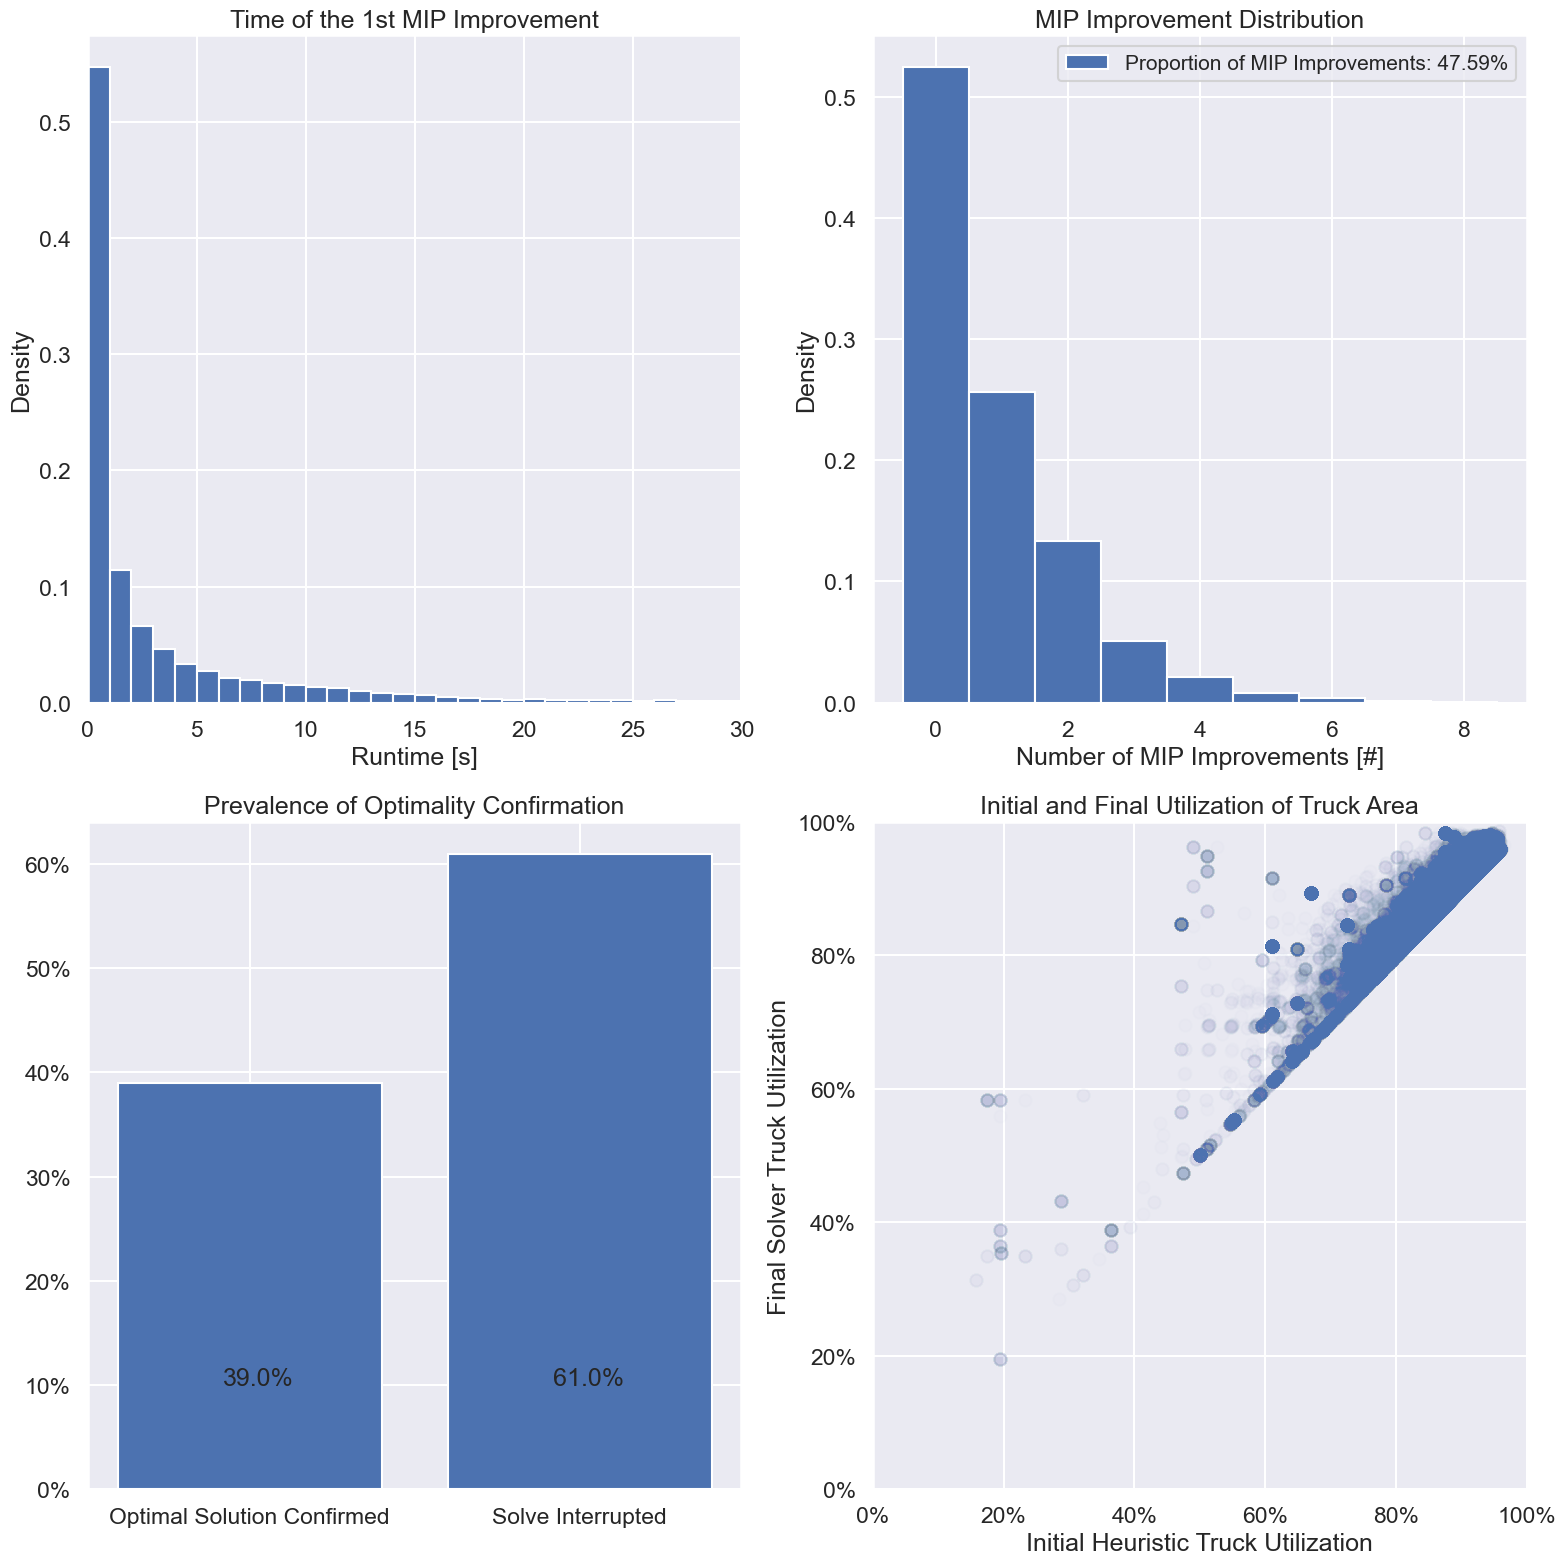

In [140]:
#fig, ax = plt.subplots(3, 2, figsize=(13, 21))
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]x

y_first_update = mip_improvements.list[1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32).fill_null(0)
y_first_update = y_first_update.map_elements(lambda x: np.nan if x == 0 else x)
ax[0,0].hist(y_first_update, bins = np.arange(0, 31, 1), density=True);
ax[0,0].set(
    xlim=(0, 30),
    ylabel="Density",
    xlabel="Runtime [s]",
    title="Time of the 1st MIP Improvement",
);


y_num_improvements = mip_improvements.list.len()-1
ax[0, 1].hist(
    y_num_improvements,
    bins=np.arange(0, 10, 1)-0.5,
    density=True,
    label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%}");
ax[0, 1].set(
    xlabel="Number of MIP Improvements [#]",
    ylabel="Density",
    title="MIP Improvement Distribution"
);
ax[0, 1].legend(fontsize=15);




# Confirmed Barplot

pattern = "Optimal Solution confirmed"
y_confirmed = df["raw"].str.contains(pattern)#.list[-1][2]

ax[1, 0].bar(
    ["Optimal Solution Confirmed", "Solve Interrupted"],
    [y_confirmed.mean(), 1-y_confirmed.mean()]
)
vals = ax[1, 0].get_yticks()
ax[1, 0].set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

for i, perc in enumerate([y_confirmed.mean(), 1-y_confirmed.mean()]):
    ax[1, 0].annotate(f"{perc:.1%}", (i-0.08, 0.1))

ax[1, 0].set_title("Prevalence of Optimality Confirmation");



# Area Ratio:
#y_packed_area_intial = mip_improvements.list[0].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
#y_packed_area_final = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

y_packed_area_initial = mip_improvements.list[0].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
y_packed_area_final = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)



ax[1, 1].scatter(y_packed_area_initial, y_packed_area_final, alpha=.01)

ax[1, 1].set(
    xlim=[0, 1],
    ylim=[0, 1],
    xlabel="Initial Heuristic Truck Utilization",
    ylabel="Final Solver Truck Utilization",
    title="Initial and Final Utilization of Truck Area"
);

vals = ax[1, 1].get_yticks()
ax[1, 1].set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
ax[1, 1].set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"Overview.{file_format}")
    plt.savefig(save_path)



In [122]:
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.467777,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,1.206,1.01,2.755,0.0,0.468765,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",4,1.206,1.01,2.34,0.0,0.302063,false,false,27522803,null,"""V55"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""
0,"""C""","""TR""","""P073421601""",3,2.01,1.31,2.79,0.045,0.78489,false,false,27522802,null,"""V09"""


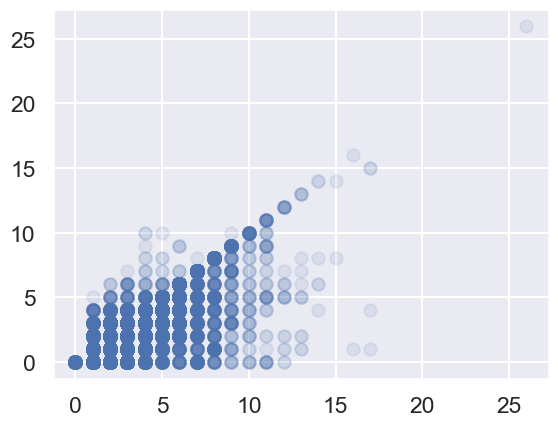

In [121]:
initally_missing = df["raw"].str.extract_all("Stack \d* missing:").list.len()
finally_missing = df["raw"].str.extract_all("Stack \d* not in final solution with items:").list.len()

plt.scatter(initally_missing, finally_missing, alpha=0.1)

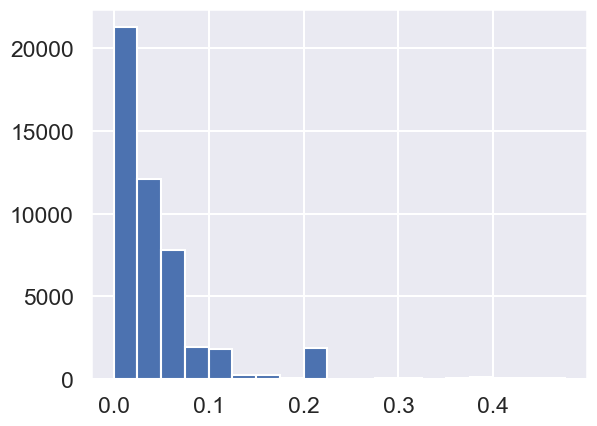

In [82]:
y_packed_area_initial = y_packed_area_initial.to_numpy()
y_packed_area_final = y_packed_area_final.to_numpy()

plt.hist(y_packed_area_final[y_packed_area_final >y_packed_area_initial] - y_packed_area_initial[y_packed_area_final >y_packed_area_initial], bins=np.arange(0, 0.5, 0.025));
#plt.yscale("log")

In [60]:
y_confirmed.mean()

0.38985

## Individual Labels:

In [ ]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

### Improvement

In [ ]:
# Number of MIP Improvements:
fig, ax = plt.subplots(figsize=(8, 5))
x = mip_improvements.list.len().to_pandas()
x = x-1
ax.hist(
    x,
    bins = np.arange(0, 10, 1)-0.5,
    density=True,
    label=f"Improvement Prevalence: {(x>0).mean():.1%}"
);
ax.set_title("Number of Improvements per MIP solver run")
ax.set_xlabel("# Improvements");
ax.set_ylabel("Density")
ax.set_xlim(-0.5, 8+0.5); print("highest number of MIP Improvements:", max(x));
ax.legend(loc="upper right");

fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"improvement-count-distribution.{file_format}")
    plt.savefig(save_path)


### Solverd

In [ ]:
pattern = "Optimal Solution confirmed"
x = df["raw"].str.contains(pattern)#.list[-1][2]


fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(
    ["Optimal Solution Confirmed", "Solve Interrupted"],
    [x.mean(), 1-x.mean()]
)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

for i, perc in enumerate([x.mean(), 1-x.mean()]):
    plt.annotate(f"{perc:.1%}", (i-0.08, 0.1))

ax.set_title("Prevalence of Optimality Confirmation");
plt.tight_layout()

fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"SolvedPrevalence.{file_format}")
    plt.savefig(save_path)


### Missing Stacks

In [ ]:
# stacks missing in heuristic solution

pattern = "Stack (\d*) missing: "
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
y = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
plt.hist(y.list.len(), bins=np.arange(0, 20, 1)-0.5);
plt.xlim([-0.5, max(y.list.len())]);
plt.xlabel("# Stacks missing in initial Solution");
#Number of missing items in final solution:

In [ ]:
pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
plt.hist(x.list.len(), bins=np.arange(0, 20, 1)-0.5);
plt.xlim([-0.5, max(x.list.len())]);
#Number of missing items in final solution:
plt.xlabel("# Stacks missing in Solver Solution");

In [ ]:
plt.scatter(y.list.len(), x.list.len(), alpha=0.1);
plt.xlabel("# Stacks missing in initial Solution");
plt.ylabel("# Stacks missing in solver Solution");

In [ ]:
pattern = "Stack (\d*) with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
y = df["raw"].str.extract_all(pattern)#.map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
y = y.map_elements(lambda x: max(int(i.split(" ")[1]) for i in x))

plt.figure(figsize=(16, 9))
plt.scatter(y, x.list.len(), alpha=0.05);
plt.xlabel("Stacks per Truck [#]")
plt.ylabel("Missing Stacks per Truck [#]");

In [ ]:
plt.hist(y-x.list.len(), bins=np.arange(0, 70, 1)+0.5);
plt.xlabel("Number of items in best solution (Stacks - missing stacks)");

In [ ]:
plt.scatter(y, y-x.list.len(), alpha=0.01);
plt.title("Planned vs packed items");
plt.xlabel("Total number of Stacks planned for the Truck")
plt.ylabel("Number of Stacks actually packed");

In [ ]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

x["total_stacks"].max()

In [ ]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)

### Time Limit Available:

In [ ]:
pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
x = df["raw"].str.extract(pattern).cast(pl.Float32)
plt.hist(x, bins=np.arange(0, 31, 1), density=True);
plt.xlim([0, 30]);

In [ ]:
pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
x = df["raw"].str.extract(pattern).cast(pl.Float32)
plt.hist(x, bins=np.arange(0, 31, 1), density=True);
plt.xlim([0, 30]);
plt.yscale("log")
plt.title("MIP Solver Time Limit Distribution");
plt.xlabel("Time Limit [s]")
plt.ylabel("log Density")

for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"log-timelimit-distribution.{file_format}")
    plt.savefig(save_path)


In [ ]:
pattern = "- after (\d*\.?\d*) \[s\]"
y = mip_improvements.list[-1].str.extract(pattern).cast(pl.Float32)
plt.hist(y, bins=np.arange(0, 31, 1));

In [ ]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
#plt.xscale("log")
#plt.yscale("log")

In [ ]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
plt.xscale("log")
plt.yscale("log")

#### First Improvement

In [ ]:
from scipy.stats import expon, gamma

pattern = "- after (\d*\.?\d*) \[s\]"
y = mip_improvements.list[1].str.extract(pattern).cast(pl.Float32)



fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(y, bins=np.arange(0, 31, 1), density=True);
ax.set_title("Distribution of first Improvement Time")
ax.set_xlabel("Time of the first Improvement [s]")
ax.set_ylabel("Density");
ax.set_xlim([0, 30])

lambd = y.mean()
distribution = expon(scale=lambd, loc=0)
xx = np.linspace(-1, 30, 1000)
yy = distribution.pdf(xx)
ax.plot(xx, yy, label="exponential Distribution");
ax.legend(loc="upper right");

#fit_alpha, fit_loc, fit_beta = gamma.fit(y.to_numpy()[~np.isnan(y.to_numpy())], loc=0)
#distribution = gamma(fit_alpha, fit_loc, fit_beta)
#xx = np.linspace(-1, 30,)
#yy = distribution.pdf(xx)
#plt.plot(xx, yy);

fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"first-improvement-distribution.{file_format}")
    plt.savefig(save_path)


In [ ]:
plt.hist(np.log(y), bins=100);

### Area Packed:

In [ ]:
print(df[1,0])

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))

y_packed_area_ratio = mip_improvements.list[0].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax.hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.025), density=False);
ax.set(xlim=[0,1]);
#ax[1].set(xlabel="packed 2D Vol Ratio")

In [ ]:
y_packed_area_intial = mip_improvements.list[0].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
y_packed_area_final = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)

sns.set(context="poster")

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))

ax[0, 0].scatter(y_packed_area_intial, y_packed_area_ratio, alpha=.01)
ax[0, 1].hist(y_packed_area_final, density=True);
ax[1, 0].hist(y_packed_area_intial, density=True);
ax[1, 1].hist(y_packed_area_final / y_packed_area_intial)

#ax[1].set(xlabel="packed 2D Vol Ratio")


sns.set(context="talk")

In [ ]:
y_packed_area_intial = mip_improvements.list[0].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
y_packed_area_final = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)

sns.set(context="poster")

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))

ax[0, 0].scatter(y_packed_area_intial, y_packed_area_final, alpha=.01)
ax[0, 1].hist(y_packed_area_final, density=True);
ax[1, 0].hist(y_packed_area_intial, density=True);
ax[1, 1].hist(y_packed_area_final / y_packed_area_intial)

#ax[1].set(xlabel="packed 2D Vol Ratio")


sns.set(context="talk")

In [ ]:
fig, ax = plt.subplots(figsize=(8,8));
ax.scatter(y_packed_area_intial, y_packed_area_final, alpha=.01)

ax.set(
    xlim=[0, 1],
    ylim=[0, 1],
    xlabel="Initial Heuristic Truck Utilization",
    ylabel="Final Solver Truck Utilization",
    title="Initial and Final Utilization of Truck Area"
);

vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals]);
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

fig.tight_layout()
for file_format in ["png", "jpg", "pdf", "svg"]:
    save_path = os.path.join(cwd, "plots", "2023-10-18-DatasetVisualization", f"Area Improvement.{file_format}")
    plt.savefig(save_path)


# Relationship between Improvements and Solved:

In [ ]:
y_improvement = (mip_improvements.list.len() > 1)
y_improvement = y_improvement.rename("Improvement")
y_improvement = y_improvement.cast(int)
y_improvement.head(5)

In [ ]:
pattern = "Optimal Solution confirmed after"
y_solved = df["raw"].str.contains(pattern)
y_solved = y_solved.rename("Solved")
y_solved = y_solved.cast(int)
y_solved.head(5)

In [ ]:
tab = pd.crosstab(
    pd.Series(y_solved, name="Solved"),
    pd.Series(y_improvement, name="Improvement"),
    normalize=False
)

tab

In [ ]:
tab = pd.crosstab(
    pd.Series(y_solved, name="Solved"),
    pd.Series(y_improvement, name="Improvement"),
    normalize=True
)

sns.heatmap(tab.iloc[:,:], annot=True, fmt=".1%");

In [ ]:
round(tab*100, 1)

In [ ]:
f"{np.corrcoef(y_solved, y_improvement)[1, 0]:.1%}"

In [ ]:
from scipy.stats import chi2_contingency

tab = pd.crosstab(y_solved, y_improvement, normalize=False)
res = chi2_contingency(tab)
res

In [ ]:
res.pvalue

In [ ]:
expexted_tab = res.expected_freq
(tab - expexted_tab)/len(df)